In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pystan

from omnitool.literature_values import *

import sys
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [21]:
def read_data():
    sfile = '/home/oliver/PhD/Gaia_Project/data/KepxDR2/Mxyu18.csv'
    df = pd.read_csv(sfile,index_col=0)
    return df

def normal(x, mu, sigma):
    return (1/np.sqrt(2*np.pi*sigma**2)) * np.exp(-(x - mu)**2/(2*sigma**2))

def posexp(x, lambd):
    A = (lambd / (np.exp(lambd*x.max())-np.exp(lambd*x.min())))
    return A * np.exp(lambd*x)

def logposexp(x, lambd):
    return (lambd/(np.exp(x.max())**lambd - np.exp(x.min())**lambd))*np.exp(x*lambd)

def posexp_bump(x, lambd, mu, sigma, w):
    A = (lambd / (np.exp(lambd*x.max())-np.exp(lambd*x.min())))
    B = 1/np.sqrt(2*np.pi*sigma**2)
    return w * A * np.exp(lambd*x) + (1-w) * B * np.exp(-(x-mu)**2/(2*sigma**2))

from scipy.stats import t
def student_t(x, nu, mu, sigma):
    return t.pdf(x, nu, mu, sigma)

In [3]:
df = read_data()
print('Applying a cut at 0. for our model')
print('Before: '+str(len(df)))
df = df[df.ast_MKs < 0.]
df = df[df.phot_MKs < 0.]
df = df[0:2000]
df = df.reindex()
print('After: '+str(len(df)))

df.head(2)

Applying a cut at 0. for our model
Before: 15587
After: 2000


,KICID,numax,numax_err,dnu,dnu_err,Teff,Teff_err,yu_logg,yu_logg_err,[Fe/H],...,ast_MH,ast_MJ,ast_M_err,r_err,phot_MKs,phot_MKs_err,phot_MH,phot_MH_err,phot_MJ,phot_MJ_err
0,757137,29.99,0.60,3.399,0.011,4751,139,2.383,0.012,-0.08,...,-2.122527,-1.556935,0.140138,11.730240,-2.081671,0.048899,-1.961939,0.048899,-1.366248,0.048899
1,892010,17.85,0.89,2.427,0.078,4834,151,2.161,0.023,0.21,...,-2.496043,-1.956587,0.226181,118.667196,-2.327920,0.140491,-2.216656,0.140491,-1.626227,0.140491


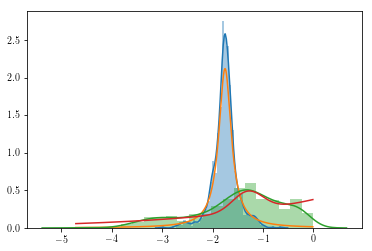

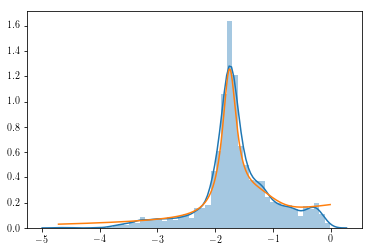

-1.752823097844531
0.5325


In [28]:
'''Step one is figuring out the different distributions we want'''
'''NOTE: RGB = 1 | HeB = 2 | U = 0'''
df.head(2)
Ks = df.ast_MKs.values
# Ks = df.phot_MKs.values
stage = df.stage.values
mKs = df.kmag.values
heb = stage == 2

x = np.linspace(Ks.min(),Ks.max(),1000)
truQ = float(len(Ks[heb]))/float(len(Ks))

# fg = normal(x, np.median(Ks[heb]), 0.15)
fg = student_t(x, 1., np.median(Ks[heb]), 0.15)
# bg = posexp(x, .5)
bg = posexp_wbump(x, .4, -1.3, .3, .8)
pp = truQ*fg + (1-truQ)*bg

sns.distplot(Ks[heb])
plt.plot(x,fg)
sns.distplot(Ks[~heb])
plt.plot(x,bg)
plt.show()

sns.distplot(Ks)
plt.plot(x,pp)
plt.show()

print(np.median(Ks[heb]))
print(truQ)

In [29]:
studentxexp = '''
functions {
    real logposexp(real x, real c0, real c1, real lambd) {
        return log(lambd/(c1^(lambd)-c0^(lambd))) + lambd*x;
    }
    
    real logposexp_bump(real x, real e0, real e1, real lambd, real mu, real sigma, real w){
        return log(w * (lambd / (e1^lambd - e0^lambd)) * exp(lambd*x) + (1-w)/sqrt(2*3.14159*sigma^2) * exp(-(x-mu)^2/(2*sigma^2)));
    }    
    
}
data {
    int<lower = 0> N;
    real d[N];
    real err[N];
    real c0;
    real c1;
}
parameters {
    real lambd;
    real <upper = 0.> bmu;
    real <lower=0.00001> bsig;
    real <lower=0.001, upper=0.999> bw;
    real <lower=0.00001> nu;
    real <upper = 0.> mu;
    real <lower=0.00001> sig;
    real <lower=0.,upper=1.> Q;
    real d_true[N];
}
model {
    d_true ~ normal(d, err);

    lambd ~ normal(0.4,0.001);
    bmu ~ normal(-1.3, .001);
    bsig ~ normal(.3, .001);
    bw ~ normal(.8,.001);
    
    nu ~ normal(1.,.001);
    mu ~ normal(-1.75,0.001);
    sig ~ normal(.15,0.001);
    Q ~ normal(0.53,.001);

    for (n in 1:N)
        target += log_mix(Q,
            student_t_lpdf(d_true[n] | nu, mu, sig),
            logposexp_bump(d_true[n] ,c0, c1, lambd, bmu, bsig, bw));
}
generated quantities{
    vector[N] post_prob;
    real ll_fg;
    real ll_bg;
    
    for (n in 1:N){
        ll_fg = log(Q) + student_t_lpdf(d_true[n] | nu, mu, sig);
        ll_bg = log(1-Q) + logposexp_bump(d_true[n] ,c0, c1, lambd, bmu, bsig, bw);
        post_prob[n] = exp(ll_fg - log_sum_exp(ll_fg, ll_bg));
    }
}

'''
sm = pystan.StanModel(model_code = studentxexp, model_name='studentxexp')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL studentxexp_1c95b24c01d41bb3febbc95f6fa26677 NOW.


In [ ]:
d = df.ast_MKs.values
err = df.ast_M_err.values
dat = {'N': len(d),
      'd': d,
      'err' : err,
      'c0' :np.exp(np.min(d)),
      'c1' : np.exp(np.max(d))}

fit = sm.sampling(data=dat, iter=3000, chains=1)

In [ ]:
import corner
trace = fit.extract()
chain = np.array([trace['nu'],trace['mu'],trace['sig'],trace['Q'],trace['lambd'],trace['bmu'],trace['bsig'],trace['bw']])
corner.corner(chain.T,labels=['nu','mu','sig','Q','lambd','bmu','bsig','bw'])
plt.show()
fit.plot(pars=['nu','mu','sig','Q','lambd','bmu','bsig','bw'])
plt.show()

In [ ]:
lambd = np.median(trace['lambd'])
bmu = np.median(trace['bmu'])
bsig = np.median(trace['bsig'])
bw = np.median(trace['bw'])
mu = np.median(trace['mu'])
mustd = np.std(trace['mu'])
sig = np.median(trace['sig'])
Q = np.median(trace['Q'])
tpp = trace['post_prob']
post_prob = np.sum(tpp,axis=0)/tpp.shape[0]

bg = posexp_bump(d, lambd, bmu, bsig, bw)
fg = normal(d, mu, sig)
L = Q*fg + (1-Q)*bg

In [ ]:
left, bottom, width, height = 0.1, 0.47, 0.85, 0.60
fig = plt.figure(1, figsize=(8,8))
sax = fig.add_axes([left, bottom, width, height])
xax = fig.add_axes([left, 0.1, width, 0.3])

cax = fig.add_axes([left+width+0.01, bottom, 0.05, height])

c = sax.scatter(Ks,mKs,s=1,c=post_prob,zorder=1000)
fig.colorbar(c, cax=cax, label='Posterior Probability')
sax.errorbar(Ks,mKs,xerr=df.ast_M_err,c='grey',fmt='none',alpha=.3,zorder=999)

sns.distplot(Ks,ax=xax)

xax.scatter(Ks,fg,s=3,label='Foreground', alpha=.5,c='orange',zorder=999)
xax.scatter(Ks,bg,s=3,label='Background', alpha=.5,c='red',zorder=998)
xax.scatter(Ks, L,s=3,label='True likelihood', alpha=.5,c='green',zorder=997)

sax.set_xlabel('Absmag in K')
sax.set_ylabel('App mag in K')
xax.set_ylabel('Units arbitrary')

In [ ]:
sns.distplot(Ks[heb])
plt.scatter(Ks,fg,s=3)
sns.distplot(Ks[~heb])
plt.scatter(Ks,bg,s=3)
plt.show()

sns.distplot(Ks)
plt.scatter(Ks,L,s=3)
plt.show()

In [ ]:
sys.exit()
'''Calculate the Kass+Raftery94 lnK values'''
lnK = np.log(post_prob) - np.log(bg_pp)

In [ ]:
#Calculate recall vs precision for various Kass+Raftery94 cut off scales
recall, precision = [], []
for lim in np.linspace(lnK.min(),lnK.max(),1000):
    mask = lnK > lim
    cheb_correct = len(Ks[mask][stage[mask]==2])
    cheb_total = len(Ks[stage==2])
    identified_total = len(Ks[mask])
    recall.append(float(cheb_correct)/float(cheb_total))
    try:
        precision.append(float(cheb_correct)/float(identified_total))
    except:
        precision.append(0.)
        
fig, ax = plt.subplots()
col = ax.scatter(recall, precision, c=np.linspace(lnK.min(),lnK.max(),1000),vmin=0.)
ax.axhline(0.9,c='r',label='0.9 precision')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.grid()
ax.set_axisbelow(True)
fig.colorbar(col, label='lnK cut-off point',extend='min')
plt.show()        


In [ ]:
import barbershop
%pylab inline
barber = barbershop.open(df,'ast_MKs','M')
barber.add_client('stage')
barber.add_client('logg')
barber.add_client('M')
barber.histograms_on(x=True, y=True)
barber.show_mirror()

In [ ]:
list(df)

In [ ]:
code = '''
functions {
    real posexp_bump(real x, real e0, real e1, real lambd, real mu, real sigma, real w){
        return log(w * (lambd / (e1^lambd - e0^lambd)) * exp(lambd*x) + (1-w)/sqrt(2*3.14159*sigma^2) * exp(-(x-mu)^2/(2*sigma^2)));
    }
}

data {
    int<lower = 0> N;
    real d[N];
    real err[N];
    real e0;
    real e1;
}
parameters {
    real <lower=0.> nu;
    real mu0;
    real <lower=0.> sig0;
    
    real <lower=0.> lambd;
    real <lower=0.,upper=1.> w;
    real mu1;
    real <lower=0.> sig1;
    
    real <lower=0.,upper=1.> Q;
    
    real d_true[N];
}
model {
    d_true ~ normal(d, err);
    
    nu ~ normal(1.,.5);
    mu0 ~ normal(-1.7,.1);
    sig0 ~ normal(0.15,.1);
    
    lambd ~ normal(.5,.1);
    mu1 ~ normal(-1.2,.1);
    sig1 ~ normal(.3,.1); 
    w ~ normal(.8, .1);
    
    Q ~ normal(0.5,.1);

    for (n in 1:N)
        target += log_mix(Q,
            student_t_lpdf(d_true[n] | nu, mu0, sig0),
            posexp_bump(d_true[n], e0, e1, lambd, mu1, sig1, w));
}
generated quantities{
    vector[N] post_prob;
    vector[N] bg_postprob;
    real ll_fg;
    real ll_bg;
    
    for (n in 1:N){
        ll_fg = log(Q) + student_t_lpdf(d_true[n] | nu, mu0, sig0);
        ll_bg = log(1-Q) + posexp_bump(d_true[n], e0, e1, lambd, mu1, sig1, w);
        post_prob[n] = exp(ll_fg - log_sum_exp(ll_fg, ll_bg));
        bg_postprob[n] = exp(ll_bg - log_sum_exp(ll_fg,ll_bg));
    }
}

'''
sm = pystan.StanModel(model_code = code, model_name='clump_model')